# Capstone Project 1 - Credit Card Fraud Detection

### Introduction
This is a capstone project of Springboard Data Science Track Bootcamp. The data is from [Kaggle](https://www.kaggle.com/c/ieee-fraud-detection/overview) closed competition. Kaggle’s data comes from Vesta’s real-world e-commerce transactions and contains a wide range of features from device type to product features.

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit

In [3]:
train_identity = pd.read_csv('data/train_identity.csv')
transaction = pd.read_csv('data/train_transaction.csv')
# mask = list(range(int(len(transaction)*0.75)))
train_transaction = transaction[:int(len(transaction)*0.75)]
test_transaction = transaction[int(len(transaction)*0.75):]

The data is broken into two files identity and transaction, which are joined by TransactionID.

In [4]:
train_transaction.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


According to the transaction dataframe shown above:
1. TransactionDT: timedelta from a given reference datetime (not an actual timestamp. (TransactionDT first value is 86400, which corresponds to the number of seconds in a day (60 * 60 * 24 = 86400) so the unit is seconds. The maximum value of TransactionDT is 15811131, so the data if from 183 days)
2. TransactionAmt: transaction payment amount in USD
3. ProductCD: product code, the product for each transaction.(The product purchased in this transaction, it can be any kind of products such as a service.)
4. card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.
5. addr1: billing region, I think it's the area code, first three number of zip code.
6. addr2: billing country
7. dist: distance. (distances between (not limited) billing address, mailing address, zip code, IP address, phone area, etc.)
8. P_emaildomain: purchase email domain. (gmail.com, yahoo.com, other)
9. R_emaildomain: recipient email domain. (gmail.com, null, other)
10. C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.
11. D1-D15: timedelta, such as days between previous transaction, etc.
12. M1-M9: match, such as names on card and address, etc.
13. Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations. (For example, how many times the payment card associated with a IP and email or address appeared in 24 hours time range, etc.)

In [5]:
train_identity.head()

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


According to the identity dataframe above:
1. Variables in this table are identity information – network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions.
2. id_01 to id_20: are collected from Vesta
3. id_21 to id_30: are collected from sourceA
4. id_31 to id_38: are collected from sourceB
5. id_30: different systems such as ios or windows
6. id_31: browsers such as chrome or safari.
7. DeviceType: mobile or desktop.
8. DeviceInfo: device information such as their system, version and so on.

### Exploratory analysis
The goal of this part is trying to find patterns and gain insight among features, and select useful features to perform better models. To first get a sense of the timespan of all these transaction data as well as how the fraud cases happen over time. I looked into feature "TransactionDT", which is defined as timedelta from a given reference datetime. The first TransactionDT is 86400 = 24 * 60 * 60 so I assume this feature is in seconds. So we can convert it back to months and days.

In [6]:
# start date is 2017-12-01
startdate = datetime.datetime.strptime('2017-12-01', '%Y-%m-%d')
train_transaction['TransactionDT'] = train_transaction['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds = x)))
test_transaction['TransactionDT'] = test_transaction['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds = x)))

<ipython-input-6-555e1ecdf8ac>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_transaction['TransactionDT'] = train_transaction['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds = x)))
<ipython-input-6-555e1ecdf8ac>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_transaction['TransactionDT'] = test_transaction['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds = x)))


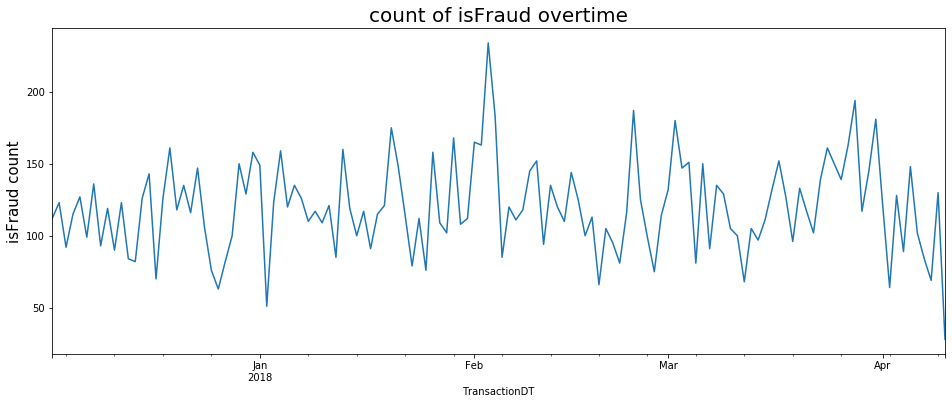

In [7]:
fig = plt.figure(figsize=(16, 6))
count_by_day = train_transaction.set_index('TransactionDT').resample('D').sum()['isFraud']
count_by_day.plot().set_ylabel('isFraud count', fontsize=15)
plt.title('count of isFraud overtime', fontsize=20)
plt.show()

**Observation**: no significant pattern visually based on days.
Now lets isFraud count hourly within a day. We then need a new feature hour.

<ipython-input-8-f87246778fc0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_transaction['hour'] = train_transaction['TransactionDT'].apply(lambda x:x.hour)


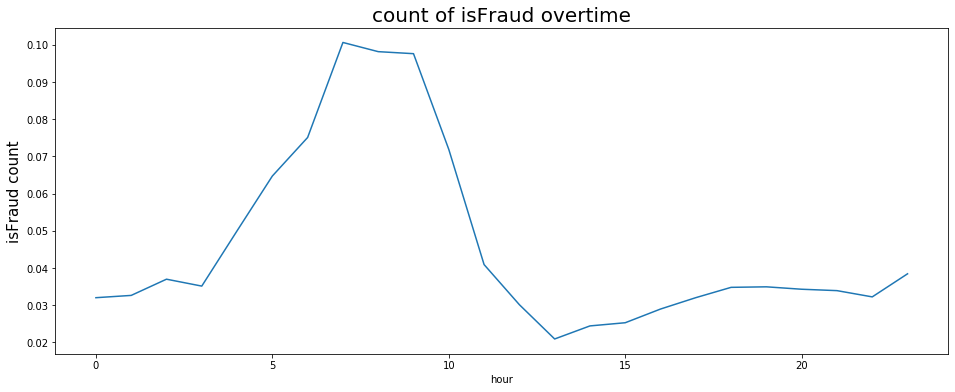

In [8]:
fig = plt.figure(figsize=(16, 6))
train_transaction['hour'] = train_transaction['TransactionDT'].apply(lambda x:x.hour)
count_by_day = train_transaction.groupby('hour').mean()['isFraud']
count_by_day.plot().set_ylabel('isFraud count', fontsize=15)
plt.title('count of isFraud overtime', fontsize=20)
plt.show()

According to the graph above, isFraud counts seems to peak during morning

### Categorical features
- ProductCD
- emaildomain
- card1 - card6
- addr1, addr2
- P_emaildomain
- R_emaildomain
- M1 - M9
- DeviceType
- DeviceInfo
- id_12 - id_38

#### ProductCD

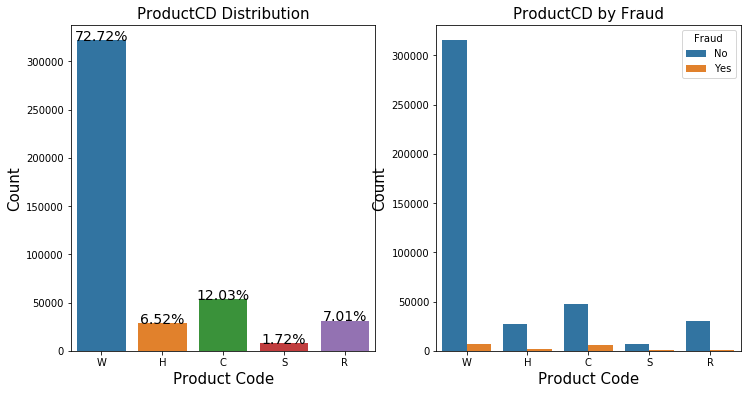

In [9]:
plt.figure(figsize=(12,6))

total = len(train_transaction)

plt.subplot(121)
g = sns.countplot(x = 'ProductCD', data = train_transaction)
g.set_title('ProductCD Distribution', fontsize = 15)
g.set_xlabel("Product Code", fontsize=15)
g.set_ylabel("Count", fontsize=15)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=14) 

plt.subplot(122)
g1 = sns.countplot(x='ProductCD', hue='isFraud', data=train_transaction)
g1.set_title('ProductCD by Fraud', fontsize = 15)
g1.set_xlabel("Product Code", fontsize=15)
g1.set_ylabel("Count", fontsize=15)
plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])
plt.show()

In [10]:
train_transaction.groupby('ProductCD')['isFraud'].value_counts(normalize = True)

ProductCD  isFraud
C          0          0.886930
           1          0.113070
H          0          0.954149
           1          0.045851
R          0          0.964043
           1          0.035957
S          0          0.938765
           1          0.061235
W          0          0.979406
           1          0.020594
Name: isFraud, dtype: float64

<Figure size 864x864 with 0 Axes>

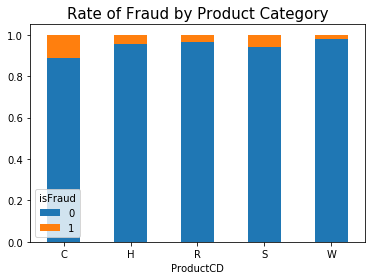

In [11]:
plt.figure(figsize=(12,12))
a = train_transaction.groupby('ProductCD')['isFraud'].value_counts(normalize = True).unstack().plot.bar(stacked = True)
a.set_title('Rate of Fraud by Product Category', fontsize = 15)
plt.xticks(rotation='horizontal')
plt.show()

**Conclusion**: Product C takes up 67.5% of fraud cases for transactions that have identity. And also have highest rate of fraud: 12%, more than double any other class of product.

**Question**: Why product C? Is there any additional information that help us better understand product C high fraud rate?

We have 2 numerical variables that we can compare between groups of products:

TransactionDT: timedelta from a given reference datetime

TransactionAmt: transaction payment amount in USD

#### P_email_domain

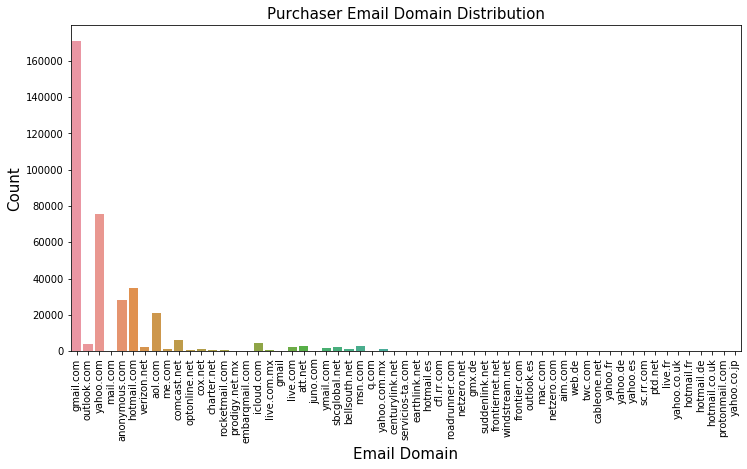

In [12]:
plt.figure(figsize=(12,6))

g = sns.countplot(x = 'P_emaildomain', data = train_transaction)
g.set_title('Purchaser Email Domain Distribution', fontsize = 15)
g.set_xlabel("Email Domain", fontsize=15)
g.set_ylabel("Count", fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

**Observation**: we can see alot of domains came from the same distributors such as hotmail.com, hotmail.fr, yahoo.com, yahoo.fr, yahoo.de, etc. We can group these domains together under the parent distributors.


#### R_emaildomain

<ipython-input-13-4a1f42742e3d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_transaction["R_parent_emaildomain"] = train_transaction["R_emaildomain"].str.split('.', expand = True)[[0]]
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


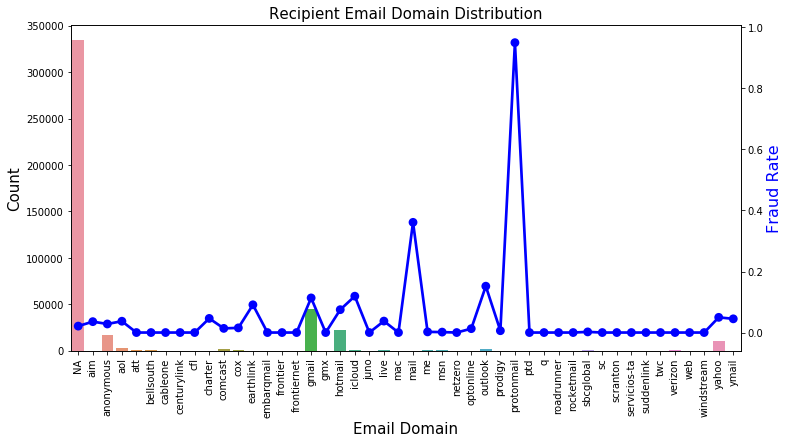

In [13]:
train_transaction["R_parent_emaildomain"] = train_transaction["R_emaildomain"].str.split('.', expand = True)[[0]]
train_transaction["R_parent_emaildomain"].fillna("NA", inplace=True)

R_emaildomain_fraud_rate = train_transaction.groupby('R_parent_emaildomain')['isFraud'].value_counts(normalize = True).unstack().fillna(0)[1]

plt.figure(figsize=(12,6))

g = sns.countplot(x = 'R_parent_emaildomain', data = train_transaction, order = R_emaildomain_fraud_rate.index)
g.set_title('Recipient Email Domain Distribution', fontsize = 15)
g.set_xlabel("Email Domain", fontsize=15)
g.set_ylabel("Count", fontsize=15)
plt.xticks(rotation= "vertical")

r = g.twinx()
r = sns.pointplot(x = R_emaildomain_fraud_rate.index, y = R_emaildomain_fraud_rate, color = "blue")
r.set_ylabel("Fraud Rate", fontsize = 16, color = "blue")
plt.show()

#### Card
We are told that card is catagorical data even though card 1, 2, 3, 5 are numerical. lets look at card4 first.

In [14]:
train_transaction.loc[:,'card1':'card5'].head()

,card1,card2,card3,card4,card5
0,13926,NaN,150.0,discover,142.0
1,2755,404.0,150.0,mastercard,102.0
2,4663,490.0,150.0,visa,166.0
3,18132,567.0,150.0,mastercard,117.0
4,4497,514.0,150.0,mastercard,102.0


In [15]:
train_transaction.describe().loc[:,'card1':'card5']

,card1,card2,card3,card5
count,442905.000000,436143.000000,442082.000000,439850.000000
mean,9862.646240,363.012608,153.330921,199.628894
std,4896.986456,158.133971,11.542589,40.809866
min,1000.000000,100.000000,100.000000,100.000000
25%,6019.000000,210.000000,150.000000,166.000000
50%,9633.000000,361.000000,150.000000,226.000000
75%,14128.000000,512.000000,150.000000,226.000000
max,18396.000000,600.000000,231.000000,237.000000


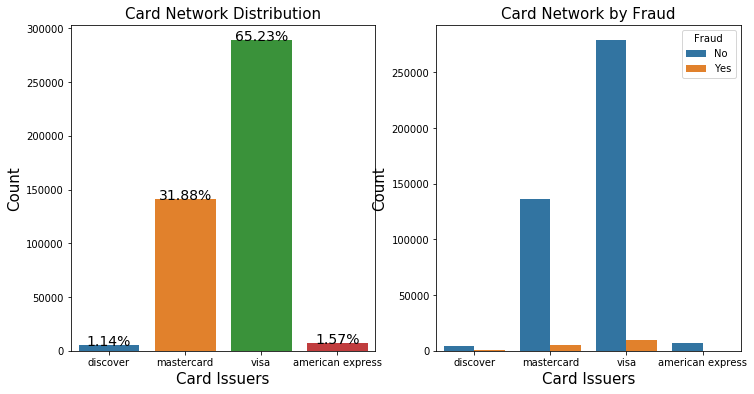

In [16]:
plt.figure(figsize=(12,6))

total = len(train_transaction)

plt.subplot(121)
g = sns.countplot(x = 'card4', data = train_transaction)
g.set_title('Card Network Distribution', fontsize = 15)
g.set_xlabel("Card Issuers", fontsize=15)
g.set_ylabel("Count", fontsize=15)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=14) 

plt.subplot(122)
g1 = sns.countplot(x='card4', hue='isFraud', data=train_transaction)
g1.set_title('Card Network by Fraud', fontsize = 15)
g1.set_xlabel("Card Issuers", fontsize=15)
g1.set_ylabel("Count", fontsize=15)
plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])
plt.show()

<Figure size 864x864 with 0 Axes>

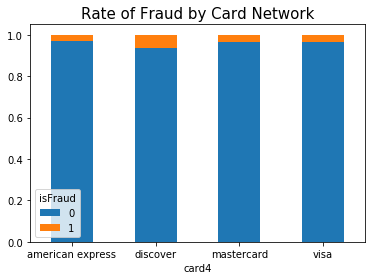

In [17]:
# visualization of table
plt.figure(figsize=(12,12))
b = train_transaction.groupby('card4')['isFraud'].value_counts(normalize = True).unstack().plot.bar(stacked = True)
b.set_title('Rate of Fraud by Card Network', fontsize = 15)
plt.xticks(rotation='horizontal')
plt.show()

**Observation**: although visa has the highest counts of isfraud, this is because visa is most used type of card. If we divide it by its population then we can see that american express have a lower fraud rate.

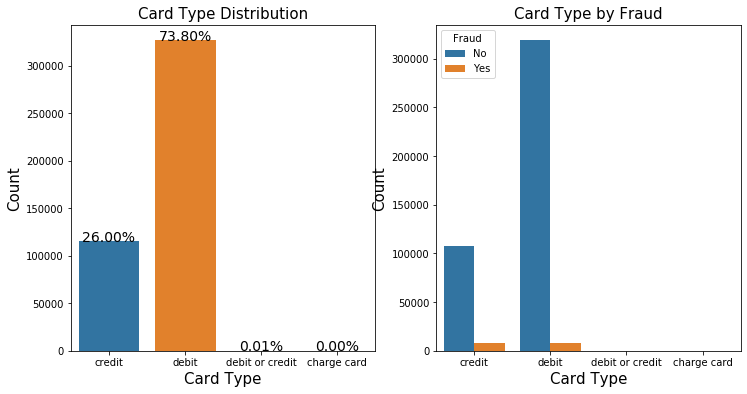

In [18]:
plt.figure(figsize=(12,6))

total = len(train_transaction)

plt.subplot(121)
g = sns.countplot(x = 'card6', data = train_transaction)
g.set_title('Card Type Distribution', fontsize = 15)
g.set_xlabel("Card Type", fontsize=15)
g.set_ylabel("Count", fontsize=15)
for p in g.patches:
    height = p.get_height()
    g.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/total*100),
            ha="center", fontsize=14) 

plt.subplot(122)
g1 = sns.countplot(x='card6', hue='isFraud', data=train_transaction)
g1.set_title('Card Type by Fraud', fontsize = 15)
g1.set_xlabel("Card Type", fontsize=15)
g1.set_ylabel("Count", fontsize=15)
plt.legend(title='Fraud', loc='best', labels=['No', 'Yes'])
plt.show()

<Figure size 864x864 with 0 Axes>

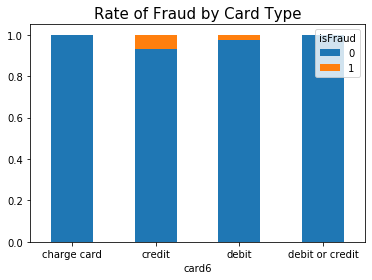

In [19]:
# visualization of table
plt.figure(figsize=(12,12))
b = train_transaction.groupby('card6')['isFraud'].value_counts(normalize = True).unstack().plot.bar(stacked = True)
b.set_title('Rate of Fraud by Card Type', fontsize = 15)
plt.xticks(rotation='horizontal')
plt.show()

**Observation**: credit card tend to have a higher fraud rate

####  M1-M9

In [20]:
train_transaction.loc[:, 'M1':'M9'].apply(pd.value_counts)

,M1,M2,M3,M4,M5,M6,M7,M8,M9
F,20.0,22078.0,45174.0,NaN,97133.0,166633.0,134814.0,98586.0,24166.0
M0,NaN,NaN,NaN,144813.0,NaN,NaN,NaN,NaN,NaN
M1,NaN,NaN,NaN,38491.0,NaN,NaN,NaN,NaN,NaN
M2,NaN,NaN,NaN,45867.0,NaN,NaN,NaN,NaN,NaN
T,213092.0,191034.0,167938.0,NaN,79031.0,141426.0,21062.0,57296.0,131716.0


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


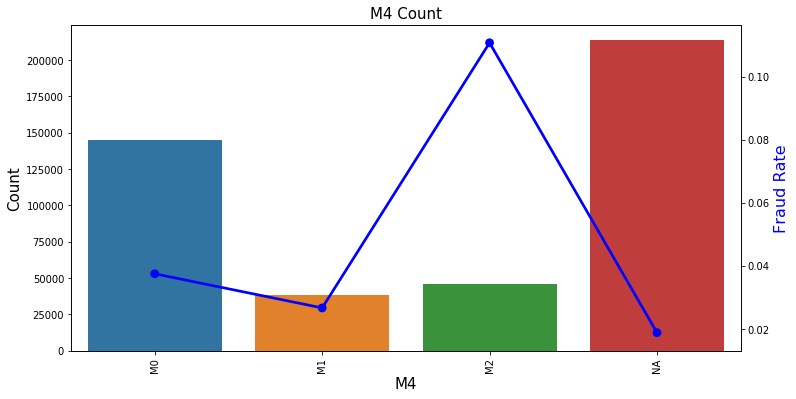

In [21]:
train_transaction['M4'].fillna("NA", inplace=True)
variable_fraud_rate = train_transaction.groupby('M4')['isFraud'].value_counts(normalize = True).unstack().fillna(0)[1]

plt.figure(figsize=(12,6))

g = sns.countplot(x = 'M4', data = train_transaction, order = variable_fraud_rate.index)
g.set_title('{} Count'.format('M4'), fontsize = 15)
g.set_xlabel("{}".format('M4'), fontsize=15)
g.set_ylabel("Count", fontsize=15)
plt.xticks(rotation= "vertical")

r = g.twinx()
r = sns.pointplot(x = variable_fraud_rate.index, y = variable_fraud_rate, color = "blue")
r.set_ylabel("Fraud Rate", fontsize = 16, color = "blue")
plt.show()

#### DeviceType

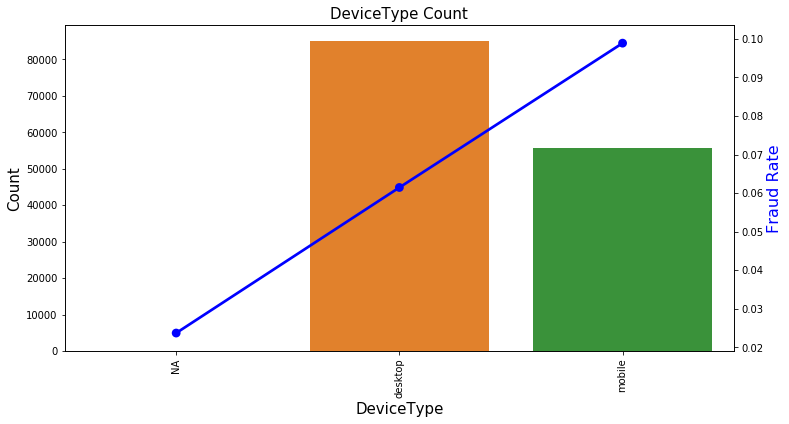

In [22]:
train_full = pd.merge(train_identity, train_transaction, on = 'TransactionID')

train_full['DeviceType'].fillna("NA", inplace=True)
variable_fraud_rate = train_full.groupby('DeviceType')['isFraud'].value_counts(normalize = True).unstack().fillna(0)[1]

plt.figure(figsize=(12,6))

g = sns.countplot(x = 'DeviceType', data = train_identity, order = variable_fraud_rate.index)
g.set_title('{} Count'.format('DeviceType'), fontsize = 15)
g.set_xlabel("{}".format('DeviceType'), fontsize=15)
g.set_ylabel("Count", fontsize=15)
plt.xticks(rotation= "vertical")

r = g.twinx()
r = sns.pointplot(x = variable_fraud_rate.index, y = variable_fraud_rate, color = "blue")
r.set_ylabel("Fraud Rate", fontsize = 16, color = "blue")
plt.show()

**Observation**: mobile device tend to have higher fraud rate.

#### DeviceInfo

In [23]:
train_full['DeviceInfo'].value_counts()

Windows                    38094
iOS Device                 16572
MacOS                      10506
Trident/7.0                 6221
rv:11.0                     1593
                           ...  
E6653 Build/32.4.A.1.54        1
SM-N920P                       1
SM-N9005 Build/LRX21V          1
SM-G935V                       1
LG-H345                        1
Name: DeviceInfo, Length: 1583, dtype: int64

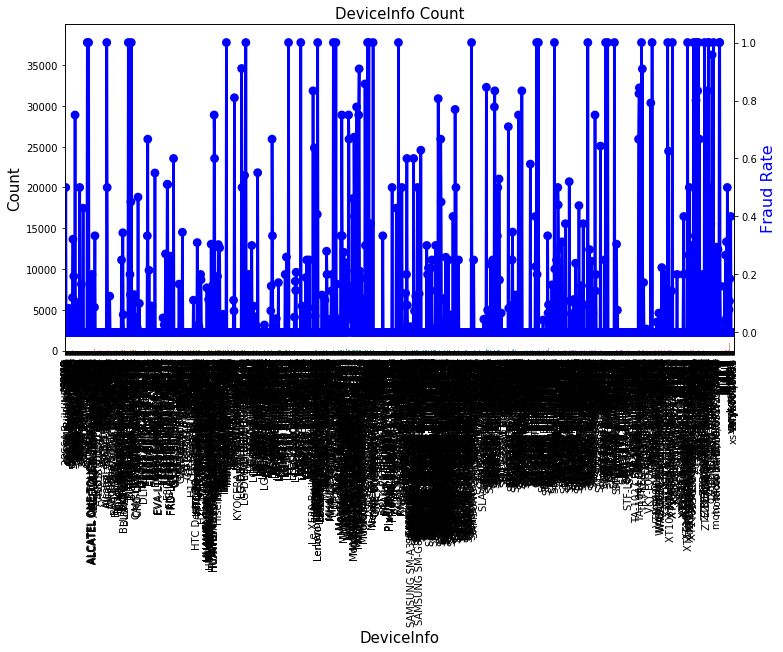

In [24]:
train_full['DeviceInfo'].fillna("NA", inplace=True)
variable_fraud_rate = train_full.groupby('DeviceInfo')['isFraud'].value_counts(normalize = True).unstack().fillna(0)[1]

plt.figure(figsize=(12,6))

g = sns.countplot(x = 'DeviceInfo', data = train_full, order = variable_fraud_rate.index)
g.set_title('{} Count'.format('DeviceInfo'), fontsize = 15)
g.set_xlabel("{}".format('DeviceInfo'), fontsize=15)
g.set_ylabel("Count", fontsize=15)
plt.xticks(rotation= "vertical")

r = g.twinx()
r = sns.pointplot(x = variable_fraud_rate.index, y = variable_fraud_rate, color = "blue")
r.set_ylabel("Fraud Rate", fontsize = 16, color = "blue")
plt.show()

In [25]:
devicelist = train_full.groupby('DeviceInfo').filter(lambda x: len(x) >500)['DeviceInfo'].unique()

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


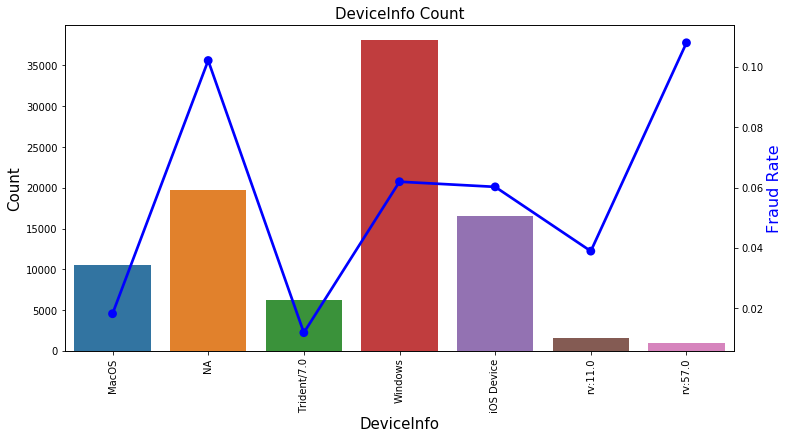

In [26]:
df = train_full[train_full['DeviceInfo'].isin(devicelist)]
df['DeviceInfo'].fillna("NA", inplace=True)
variable_fraud_rate = df.groupby('DeviceInfo')['isFraud'].value_counts(normalize = True).unstack().fillna(0)[1]

plt.figure(figsize=(12,6))

g = sns.countplot(x = 'DeviceInfo', data = df, order = variable_fraud_rate.index)
g.set_title('{} Count'.format('DeviceInfo'), fontsize = 15)
g.set_xlabel("{}".format('DeviceInfo'), fontsize=15)
g.set_ylabel("Count", fontsize=15)
plt.xticks(rotation= "vertical")

r = g.twinx()
r = sns.pointplot(x = variable_fraud_rate.index, y = variable_fraud_rate, color = "blue")
r.set_ylabel("Fraud Rate", fontsize = 16, color = "blue")
plt.show()

**Observation**: MacOS have relatively low fraud rate.

### Numerical Features

#### TransactionAmt

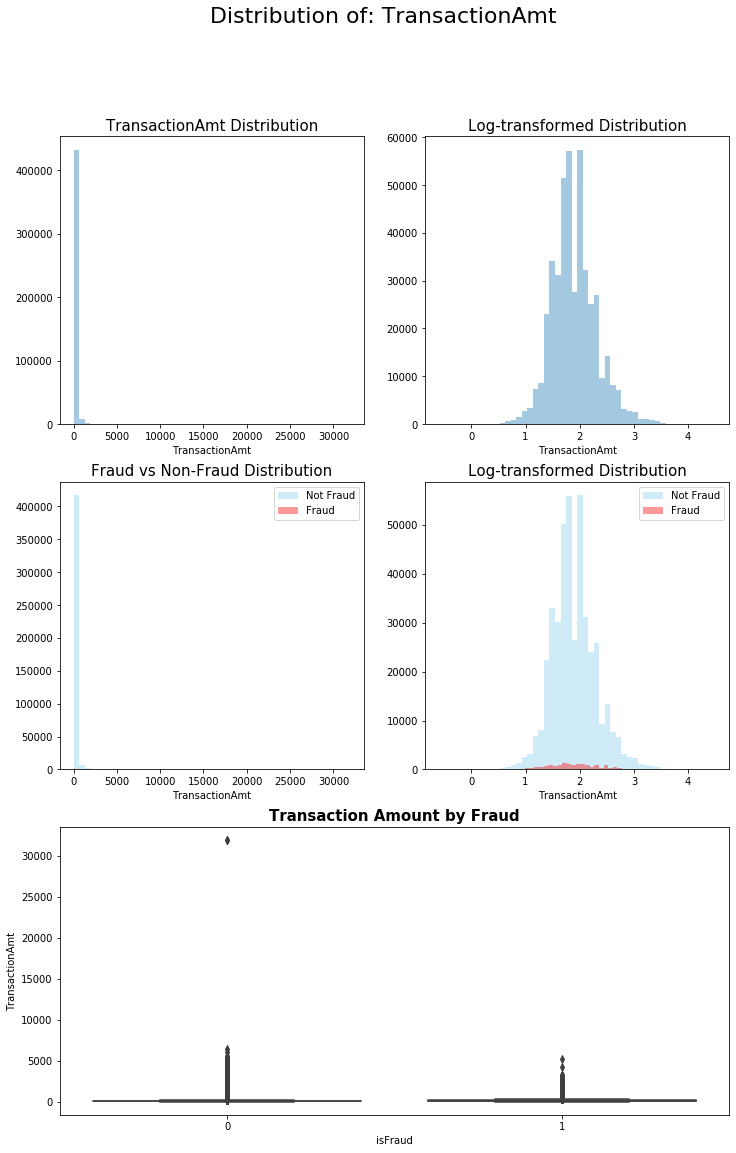

In [27]:
plt.figure(figsize=(12,18))
plt.suptitle('Distribution of: {}'.format('TransactionAmt'), fontsize=22)

plt.subplot(321)
sns.distplot(train_transaction['TransactionAmt'], kde= False)
plt.title('{} Distribution'.format('TransactionAmt'), fontsize = 15)

plt.subplot(322)
sns.distplot(np.log10(train_transaction['TransactionAmt']), kde= False)
plt.title('Log-transformed Distribution', fontsize = 15)


plt.subplot(323)
sns.distplot(train_transaction[train_transaction['isFraud'] == 0]['TransactionAmt'], color = 'skyblue', kde= False, label = 'Not Fraud')
sns.distplot(train_transaction[train_transaction['isFraud'] == 1]['TransactionAmt'], color = 'red', kde= False , label = 'Fraud')
plt.title('Fraud vs Non-Fraud Distribution', fontsize = 15)
plt.legend()

plt.subplot(324)
sns.distplot(np.log10(train_transaction[train_transaction['isFraud'] == 0]['TransactionAmt']), color = 'skyblue', kde= False, label = 'Not Fraud')
sns.distplot(np.log10(train_transaction[train_transaction['isFraud'] == 1]['TransactionAmt']), color = 'red', kde= False , label = 'Fraud')
plt.title('Log-transformed Distribution', fontsize = 15)
plt.legend()

plt.subplot(313)
sns.boxplot(x = 'isFraud', y = 'TransactionAmt', data = train_transaction)
plt.title('Transaction Amount by Fraud', fontsize = 15,  weight='bold')
plt.show()

**Observation**: most transactions are small (less than $200)

#### Distance

In [28]:
def visualize_num_variable(variable, df=train_full.copy()):
    # check for homogeneity:
    if len(df[variable].unique()) <= 1:
        print('{} is a homogeneous set'.format(variable))
        return
    
    # check for NAs and Zeros
    if df[variable].isnull().values.any():
        df = train_full.dropna(subset=[variable])

    if df[variable].min() < 0:
        plt.figure(figsize=(12,12))
        plt.suptitle('Distribution of: {}'.format(variable), fontsize=22)
    
        plt.subplot(221)
        sns.distplot(df[variable], kde= False)
        plt.title('{} Distribution'.format(variable), fontsize = 15)
        
        plt.subplot(222)
        sns.distplot(df[df['isFraud'] == 0][variable], color = 'skyblue', kde= False, label = 'Not Fraud')
        sns.distplot(df[df['isFraud'] == 1][variable], color = 'red', kde= False , label = 'Fraud')
        plt.title('Fraud vs Non-Fraud Distribution', fontsize = 15)
        plt.legend()
        
        plt.subplot(212)
        sns.boxplot(x = 'isFraud', y = variable, data = df)
        plt.title('{} by Fraud'.format(variable), fontsize = 15,  weight='bold')
        
    else:
        smallest_value = df[df[variable] != 0][variable].min()
        if df[variable].min() == 0:
            df[variable].replace(0, smallest_value/10, inplace=True)       

        plt.figure(figsize=(12,18))
        plt.text(x=0.5, y=0.5,
                 s="Zeros have been replaced with {} to avoid log infinity".format(smallest_value/10),
                 fontsize=12,horizontalalignment='center')

        plt.suptitle('Distribution of: {}'.format(variable), fontsize=22)

        plt.subplot(321)
        sns.distplot(df[variable], kde= False)
        plt.title('{} Distribution'.format(variable), fontsize = 15)

        plt.subplot(322)
        sns.distplot(np.log10(df[variable]), kde= False)
        plt.title('Log-transformed Distribution', fontsize = 15)


        plt.subplot(323)
        sns.distplot(df[df['isFraud'] == 0][variable], color = 'skyblue', kde= False, label = 'Not Fraud')
        sns.distplot(df[df['isFraud'] == 1][variable], color = 'red', kde= False , label = 'Fraud')
        plt.title('Fraud vs Non-Fraud Distribution', fontsize = 15)
        plt.legend()

        plt.subplot(324)
        sns.distplot(np.log10(df[df['isFraud'] == 0][variable]), color = 'skyblue', kde= False, label = 'Not Fraud')
        sns.distplot(np.log10(df[df['isFraud'] == 1][variable]), color = 'red', kde= False , label = 'Fraud')
        plt.title('Log-transformed Distribution', fontsize = 15)
        plt.legend()

        plt.subplot(313)
        sns.boxplot(x = 'isFraud', y = variable, data = df)
        plt.title('{} by Fraud'.format(variable), fontsize = 15,  weight='bold')
        plt.show()

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/generic.py:6746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


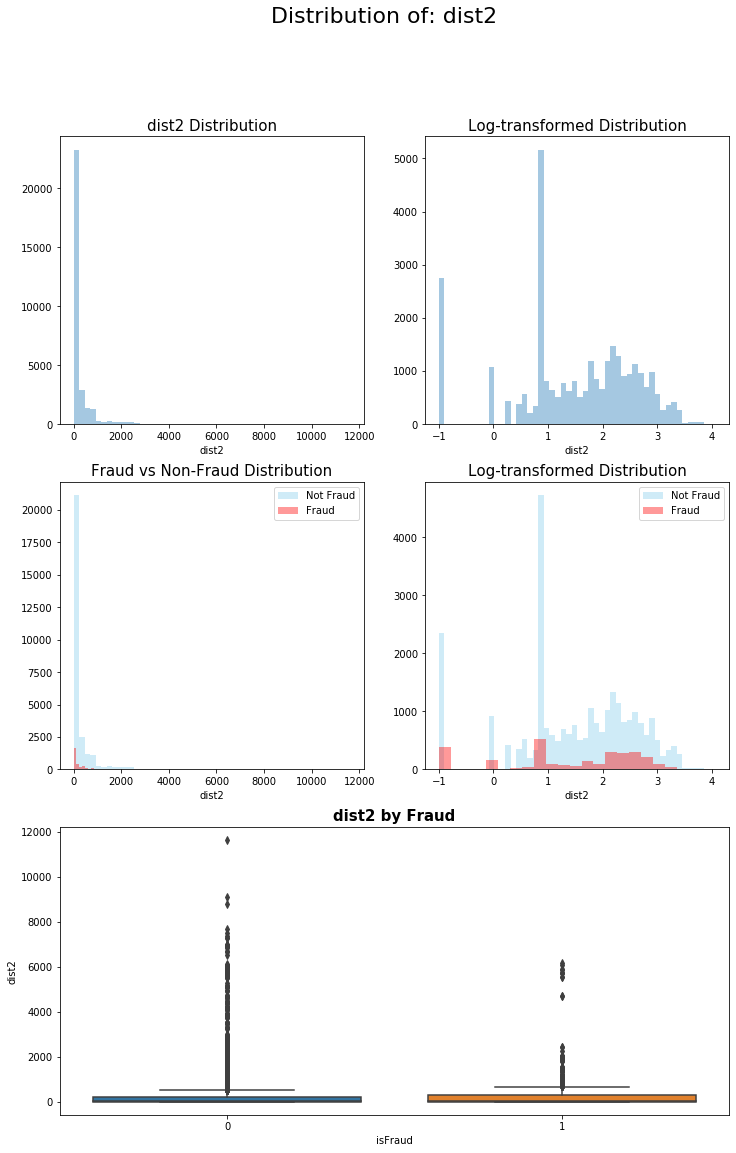

In [29]:
visualize_num_variable('dist2')

#### C
Counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.

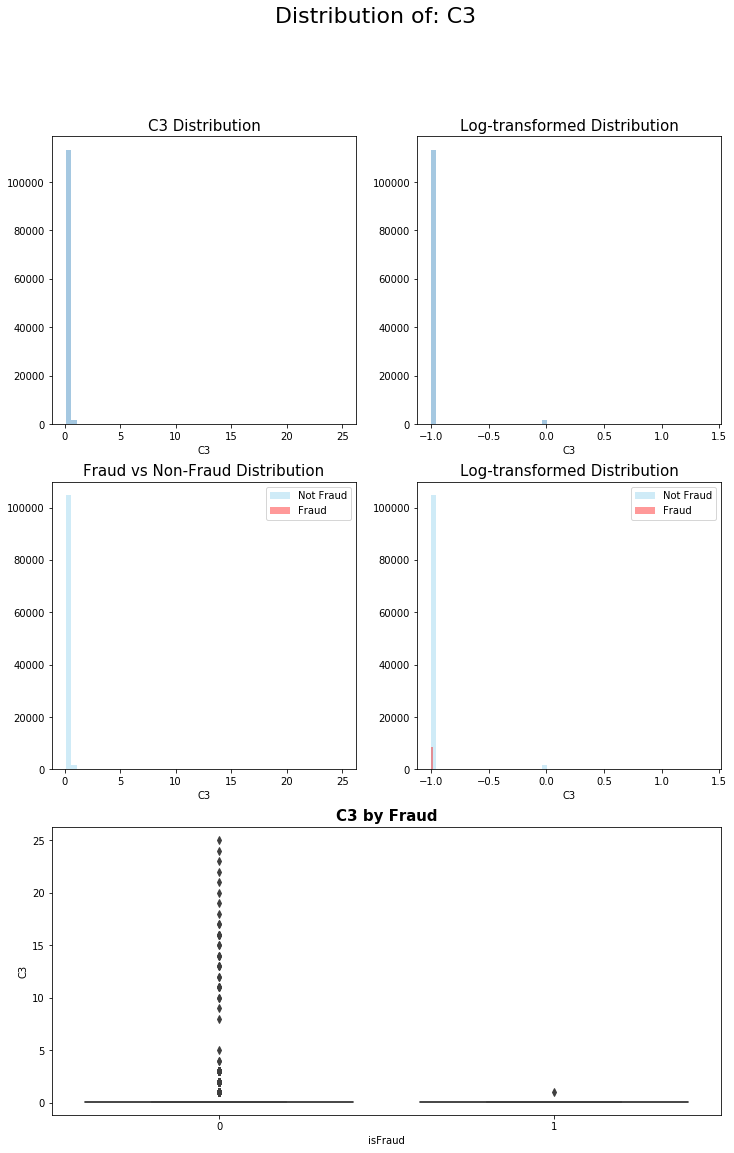

In [30]:
visualize_num_variable('C3')

**Observation**: the higher C3 the lower fraud.
#### D
Timedelta, such as days between previous transaction, etc.

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/generic.py:6746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


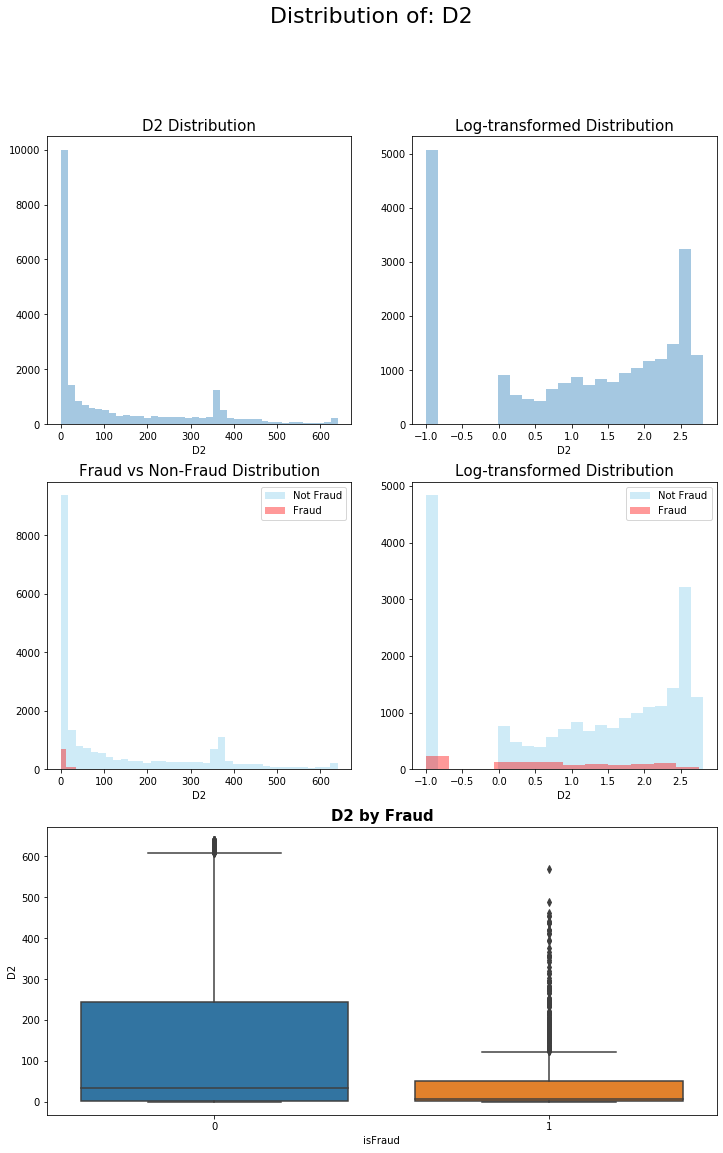

In [31]:
visualize_num_variable('D2')

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/generic.py:6746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


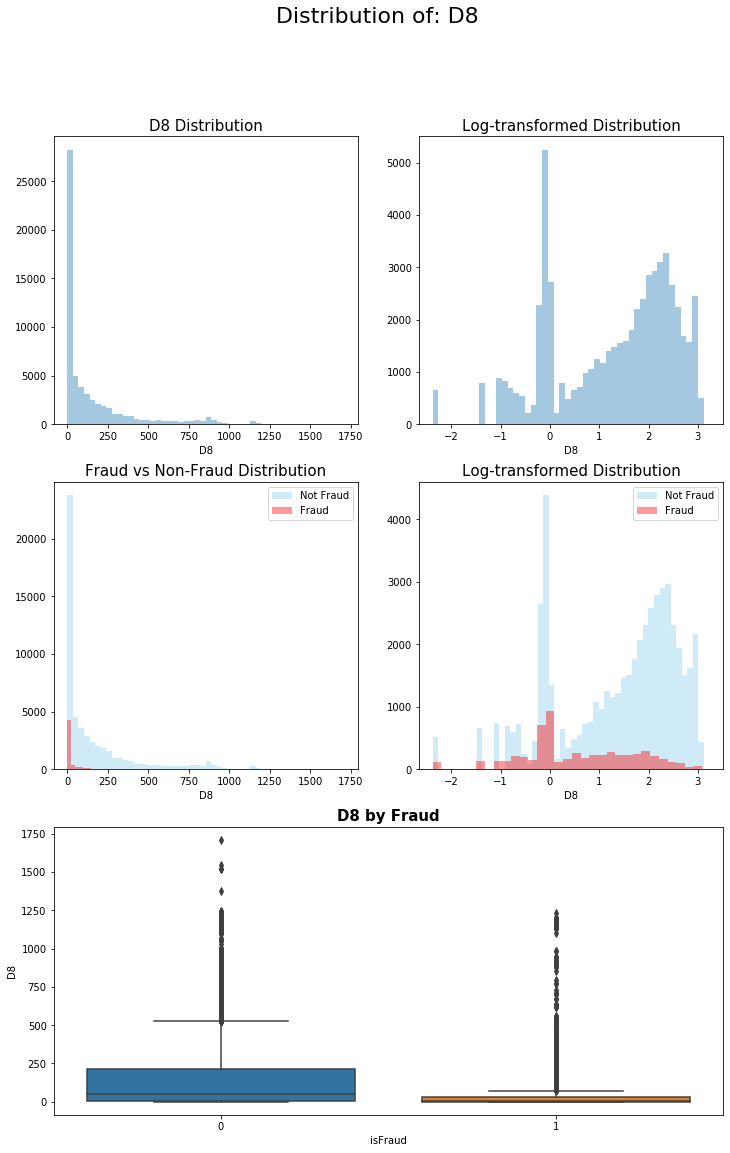

In [32]:
visualize_num_variable('D8')

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/generic.py:6746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


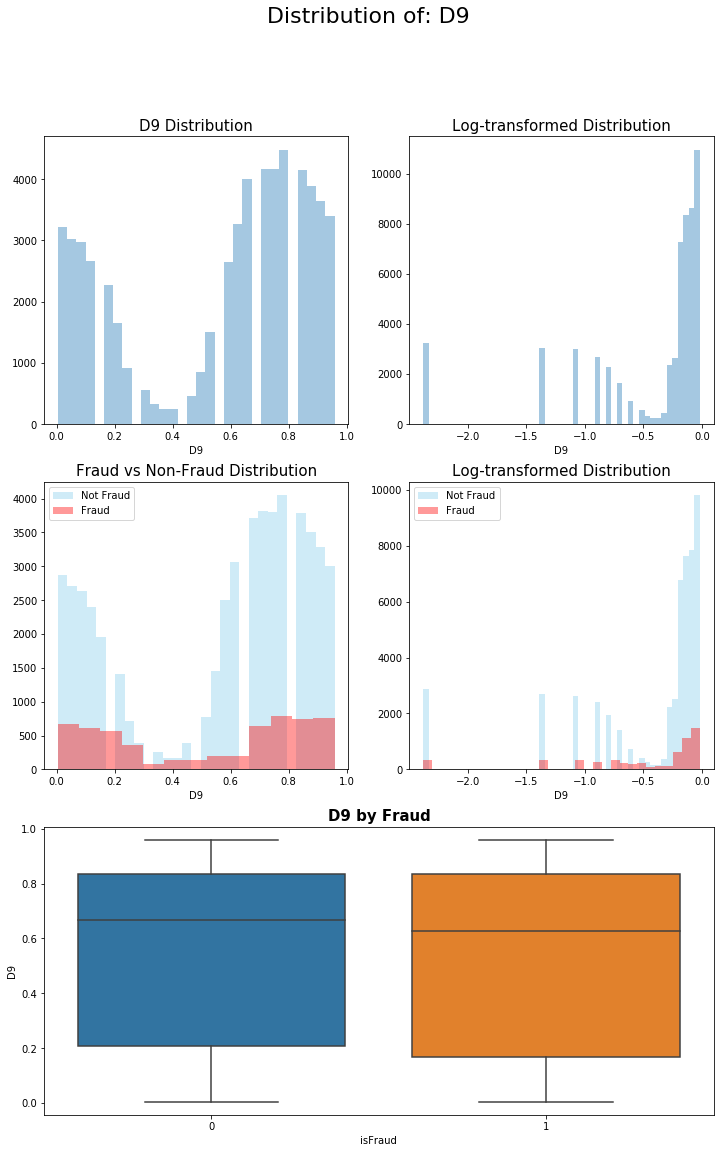

In [33]:
visualize_num_variable('D9')

### Conclusion for EDA:

1. Target variable has class imbalance problem where instance of fraud is much lower than non-fraud

2. Multiple columns contain too many missing values

3. Several columns are homogeneous, therefore, prodvide no useful information in predicting the target variable (this may not be the case for transaction table since we are using a joined table)

4. There is period of time where instances of non-fraud far exceed the usual proportion of non-fraud to fraud 

5. Basic understand of variables can help us do simple feature engineering

We will deal with each problem with the purpose of improving the prediction accuracy. But first, let's try a default XGBoost model provided by Vesta. We can use this model as a baseline to compare the improvement (or reduction) of each engineered feature, change, and alteration that  we made along the way.

### Models

In [168]:
identity = pd.read_csv('data/train_identity.csv')
transaction = pd.read_csv('data/train_transaction.csv')
# mask = list(range(int(len(transaction)*0.75)))


In [169]:
transaction.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [170]:
df = transaction.merge(identity, on='TransactionID', how='left')
df.shape

(590540, 434)

In [171]:
df.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [172]:
cat_cols = [
    'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6',
    'addr1', 'addr2', 'P_emaildomain', 'R_emaildomain', 'DeviceType', 'DeviceInfo',
] + [f'M{n}' for n in range(1, 10)] + [f'id_{n}' for n in range(12, 39)]
num_cols = list(set(df.columns) - set(cat_cols))

In [176]:
a = df[num_cols].isnull().any()
df_na_num_cols = a[a].index
nas = {}
for n in df_na_num_cols:
    df[f'{n}_isna'] = df[n].isnull()
    med = df[n].median()
    df[n].fillna(med, inplace=True)
    nas[n] = med

In [178]:
df.head().transpose()

,0,1,2,3,4
TransactionID,2987000,2987001,2987002,2987003,2987004
isFraud,0,0,0,0,0
TransactionDT,86400,86401,86469,86499,86506
TransactionAmt,68.5,29,59,50,50
ProductCD,W,W,W,W,H
...,...,...,...,...,...
V258_isna,True,True,True,True,False
V275_isna,True,True,True,True,False
V188_isna,True,True,True,True,False
V257_isna,True,True,True,True,False


In [180]:
df_train = df[:int(len(df)*0.75)]
df_test = df[int(len(df)*0.75):]

In [181]:
for c in cat_cols:
    df_train[c] = df_train[c].fillna("missing")
for c in cat_cols:
    df_test[c] = df_test[c].fillna("missing")

<ipython-input-181-6c25315bef71>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[c] = df_train[c].fillna("missing")
<ipython-input-181-6c25315bef71>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[c] = df_test[c].fillna("missing")


In [184]:
cats = {}
for c in cat_cols:
    df_train[c] = df_train[c].astype("category")
    df_train[c].cat.add_categories('unknown', inplace=True)
    cats[c] = df_train[c].cat.categories

for k, v in cats.items():
    df_test[k][~df_test[k].isin(v)] = 'unknown'

<ipython-input-184-4ee9ff6b18a4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[c] = df_train[c].astype("category")
<ipython-input-184-4ee9ff6b18a4>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[k][~df_test[k].isin(v)] = 'unknown'
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/generic.py:8767: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

In [185]:
from pandas.api.types import CategoricalDtype
for k, v in cats.items():
    new_dtype = CategoricalDtype(categories=v, ordered=True)
    df_test[k] = df_test[k].astype(new_dtype)
for c in cat_cols:
    df_train[c] = df_train[c].cat.codes
    df_test[c] = df_test[c].cat.codes

<ipython-input-185-b7834e845051>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[k] = df_test[k].astype(new_dtype)
<ipython-input-185-b7834e845051>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[c] = df_train[c].cat.codes
<ipython-input-185-b7834e845051>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/us

In [189]:
y_train = df_train['isFraud']
X_train = df_train.drop('isFraud', axis=1)
X_test = df_test.drop('isFraud', axis=1)
y_test = df_test['isFraud']

In [193]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
a_score = accuracy_score(y_test, y_pred)

In [195]:
print('Accuracy score is: ' + str(a_score))

Accuracy score is: 0.9067429810004403


In [202]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
roc_score = roc_auc_score(y_test, y_pred)
print('ROC-ACU score is: ' + str(roc_score))

ROC-ACU score is: 0.6769005858210264


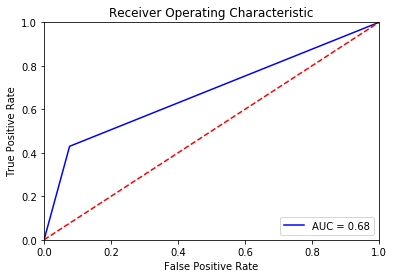

In [203]:
fpr, tpr, threshold = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=400, max_features=0.3, min_samples_leaf=20, n_jobs=-1, verbose=1)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
roc_score_rf = roc_auc_score(y_test, y_pred_rf)
print(roc_score_rf)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.6min
